In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from scipy.spatial.distance import pdist, squareform
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [3]:
format_plots()
#format_pizza_plots()
c = PlotConfig()

In [4]:
## update data
def remove_crl_male(df):
    max=39
    df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    #syll=0
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

def remove_crl_female(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    #syll=0
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [5]:
# arrange data
# pseudo data males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_pseudotime_v02.parquet')
m_psd = pd.read_parquet(path)
m_psd=m_psd.reset_index()
m_psd=m_psd[['uuid','pseudotime_rank','age','pseudo_age']]

#make sure only animals in clean v2 are in the male dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_v2.parquet')
df_males = pd.read_parquet(path)
df_males = remove_crl_male(df_males)
m_psd = df_males.merge(m_psd, on='uuid', how='left')

#do some cleaning up
m_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
m_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
m_psd['remapped_bins'] = m_psd['pseudo_age']
m_psd.set_index(['remapped_bins'], 
                append=True, inplace=True)
m_psd = m_psd.filter(regex=r'\d')

In [6]:
#dm = squareform(pdist(df.filter(regex=r'\d'), metric='jensenshannon'))
#dm[np.diag_indices_from(dm)] = np.nan

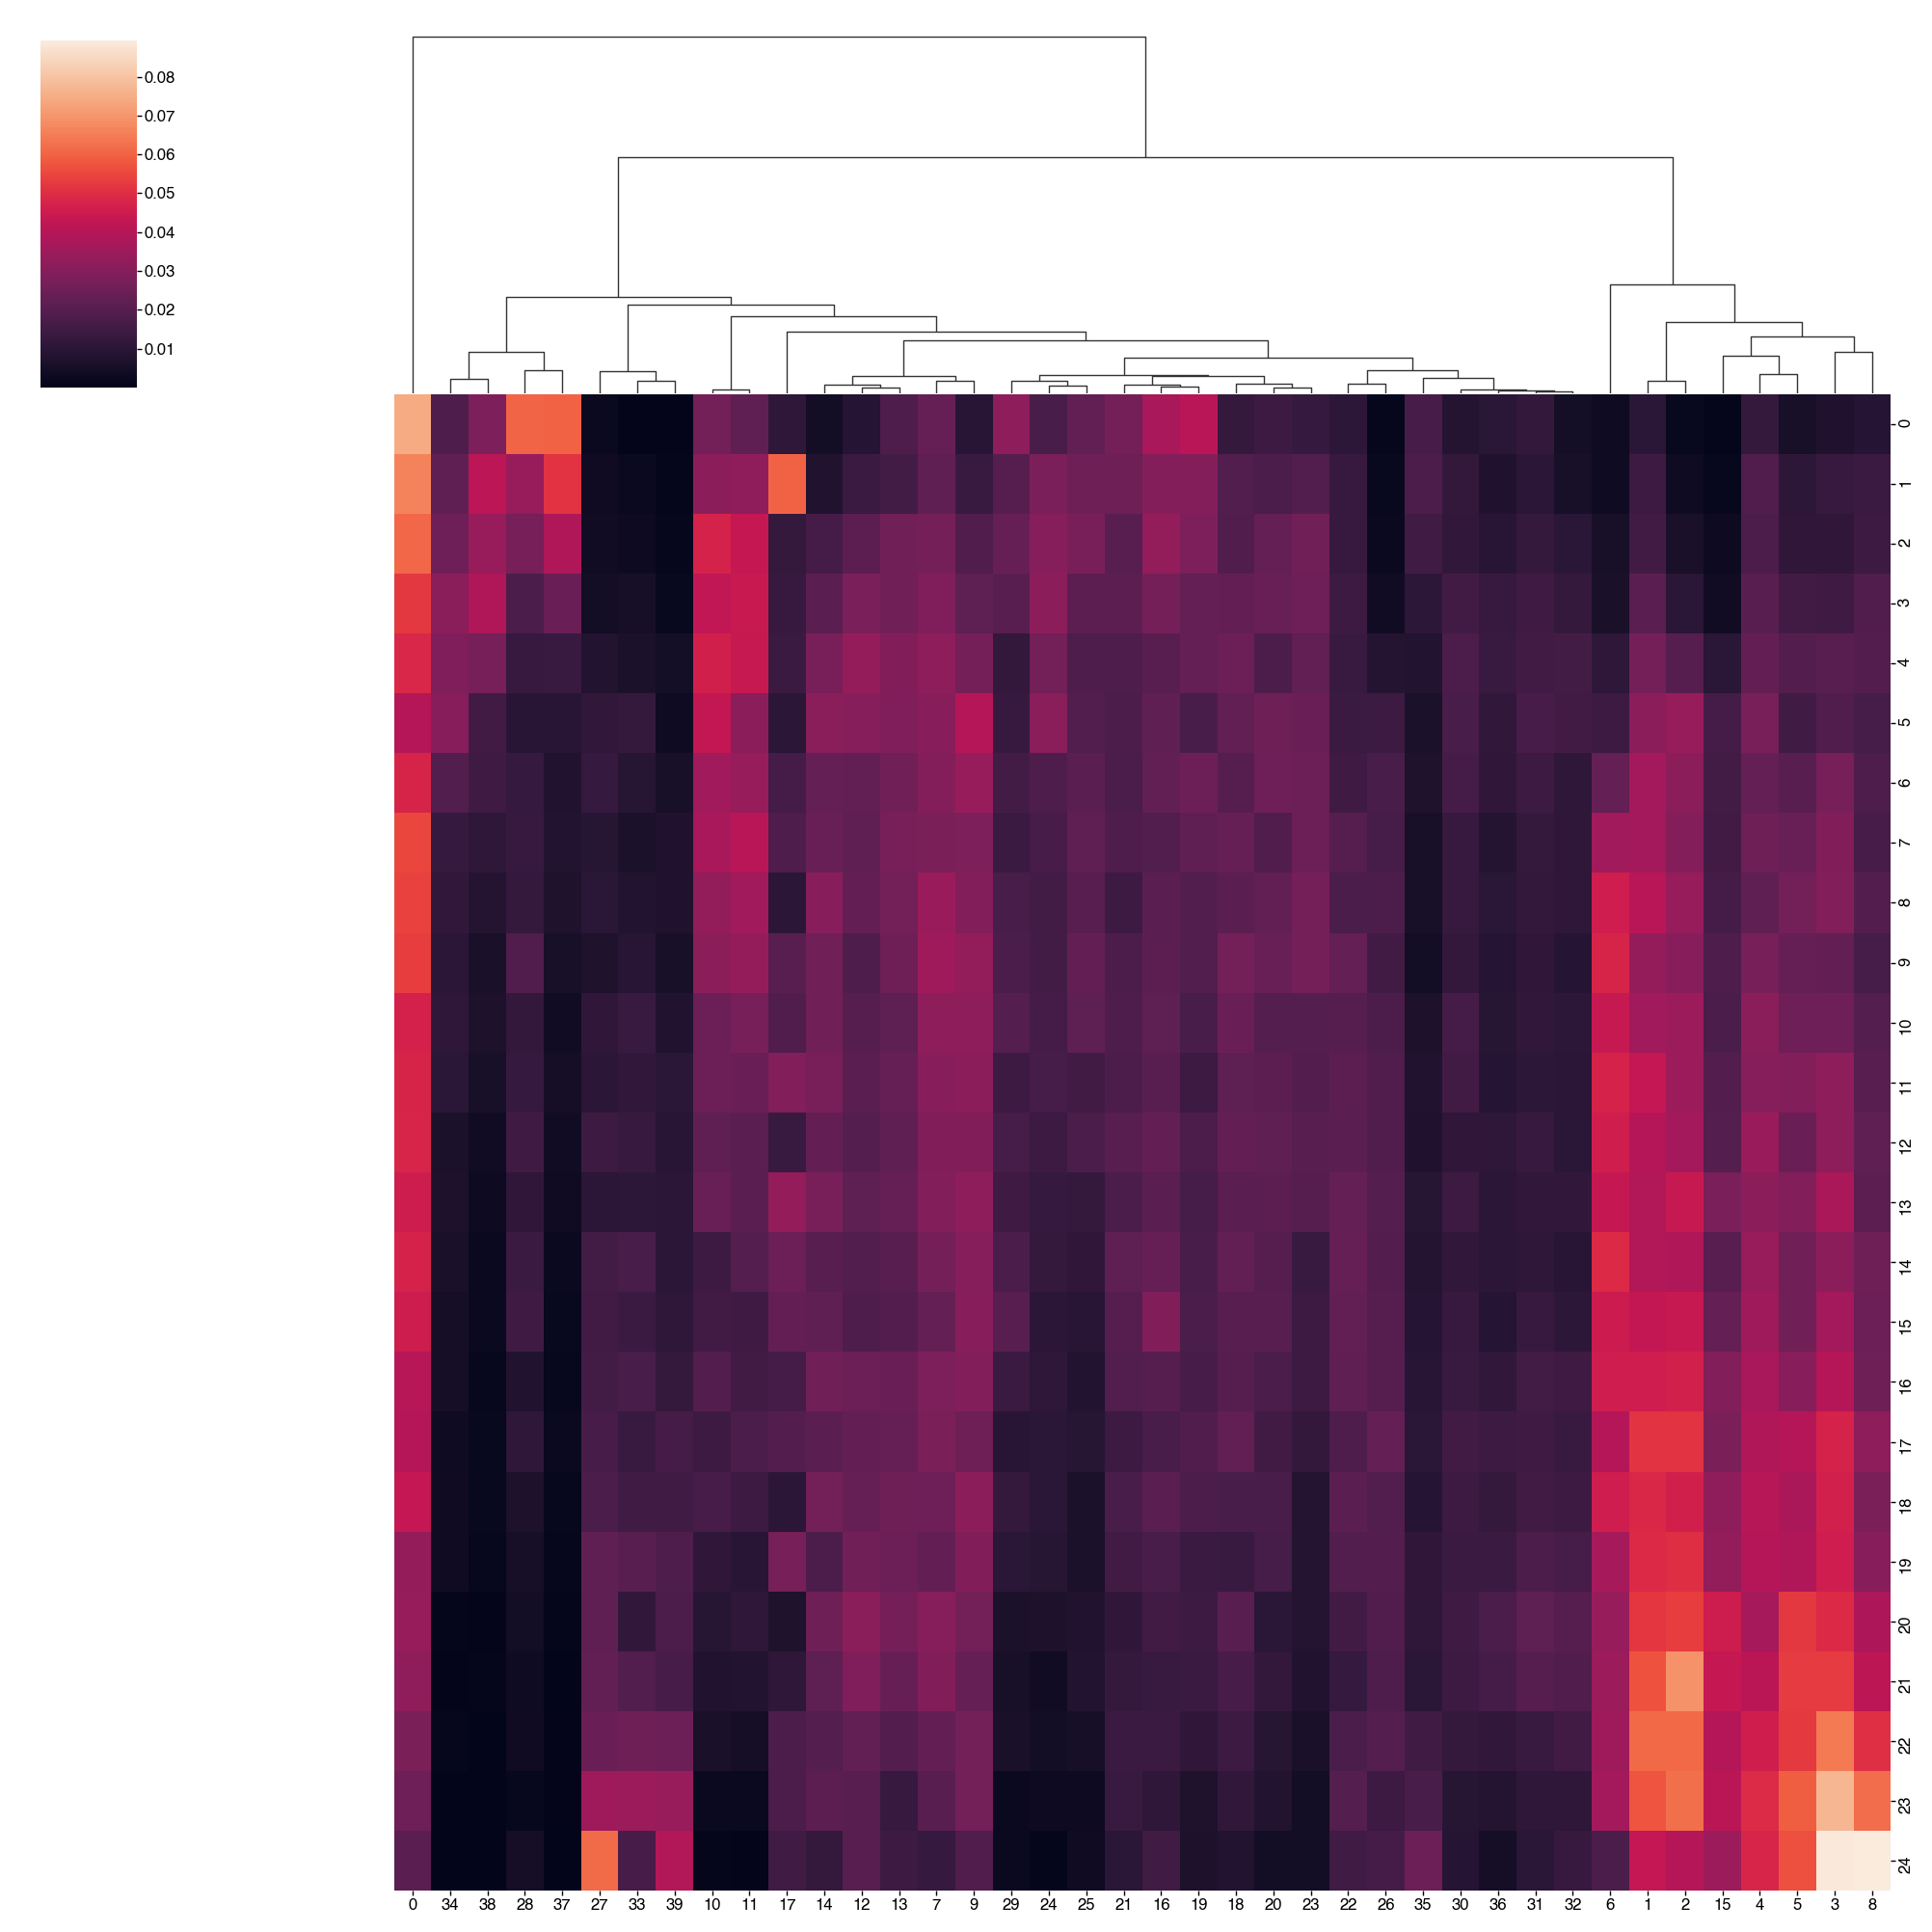

In [7]:
# get average syllable change over age
data= m_psd.copy()
mean_su = data.groupby('remapped_bins').mean()
cmg=sns.clustermap(mean_su.to_numpy(),
                   col_cluster=True,row_cluster=None,
                   method='average',
                   #metric='jensenshannon',
                   metric='sqeuclidean',
                   )
s=cmg.dendrogram_col.reordered_ind #reordered columns of the matrix

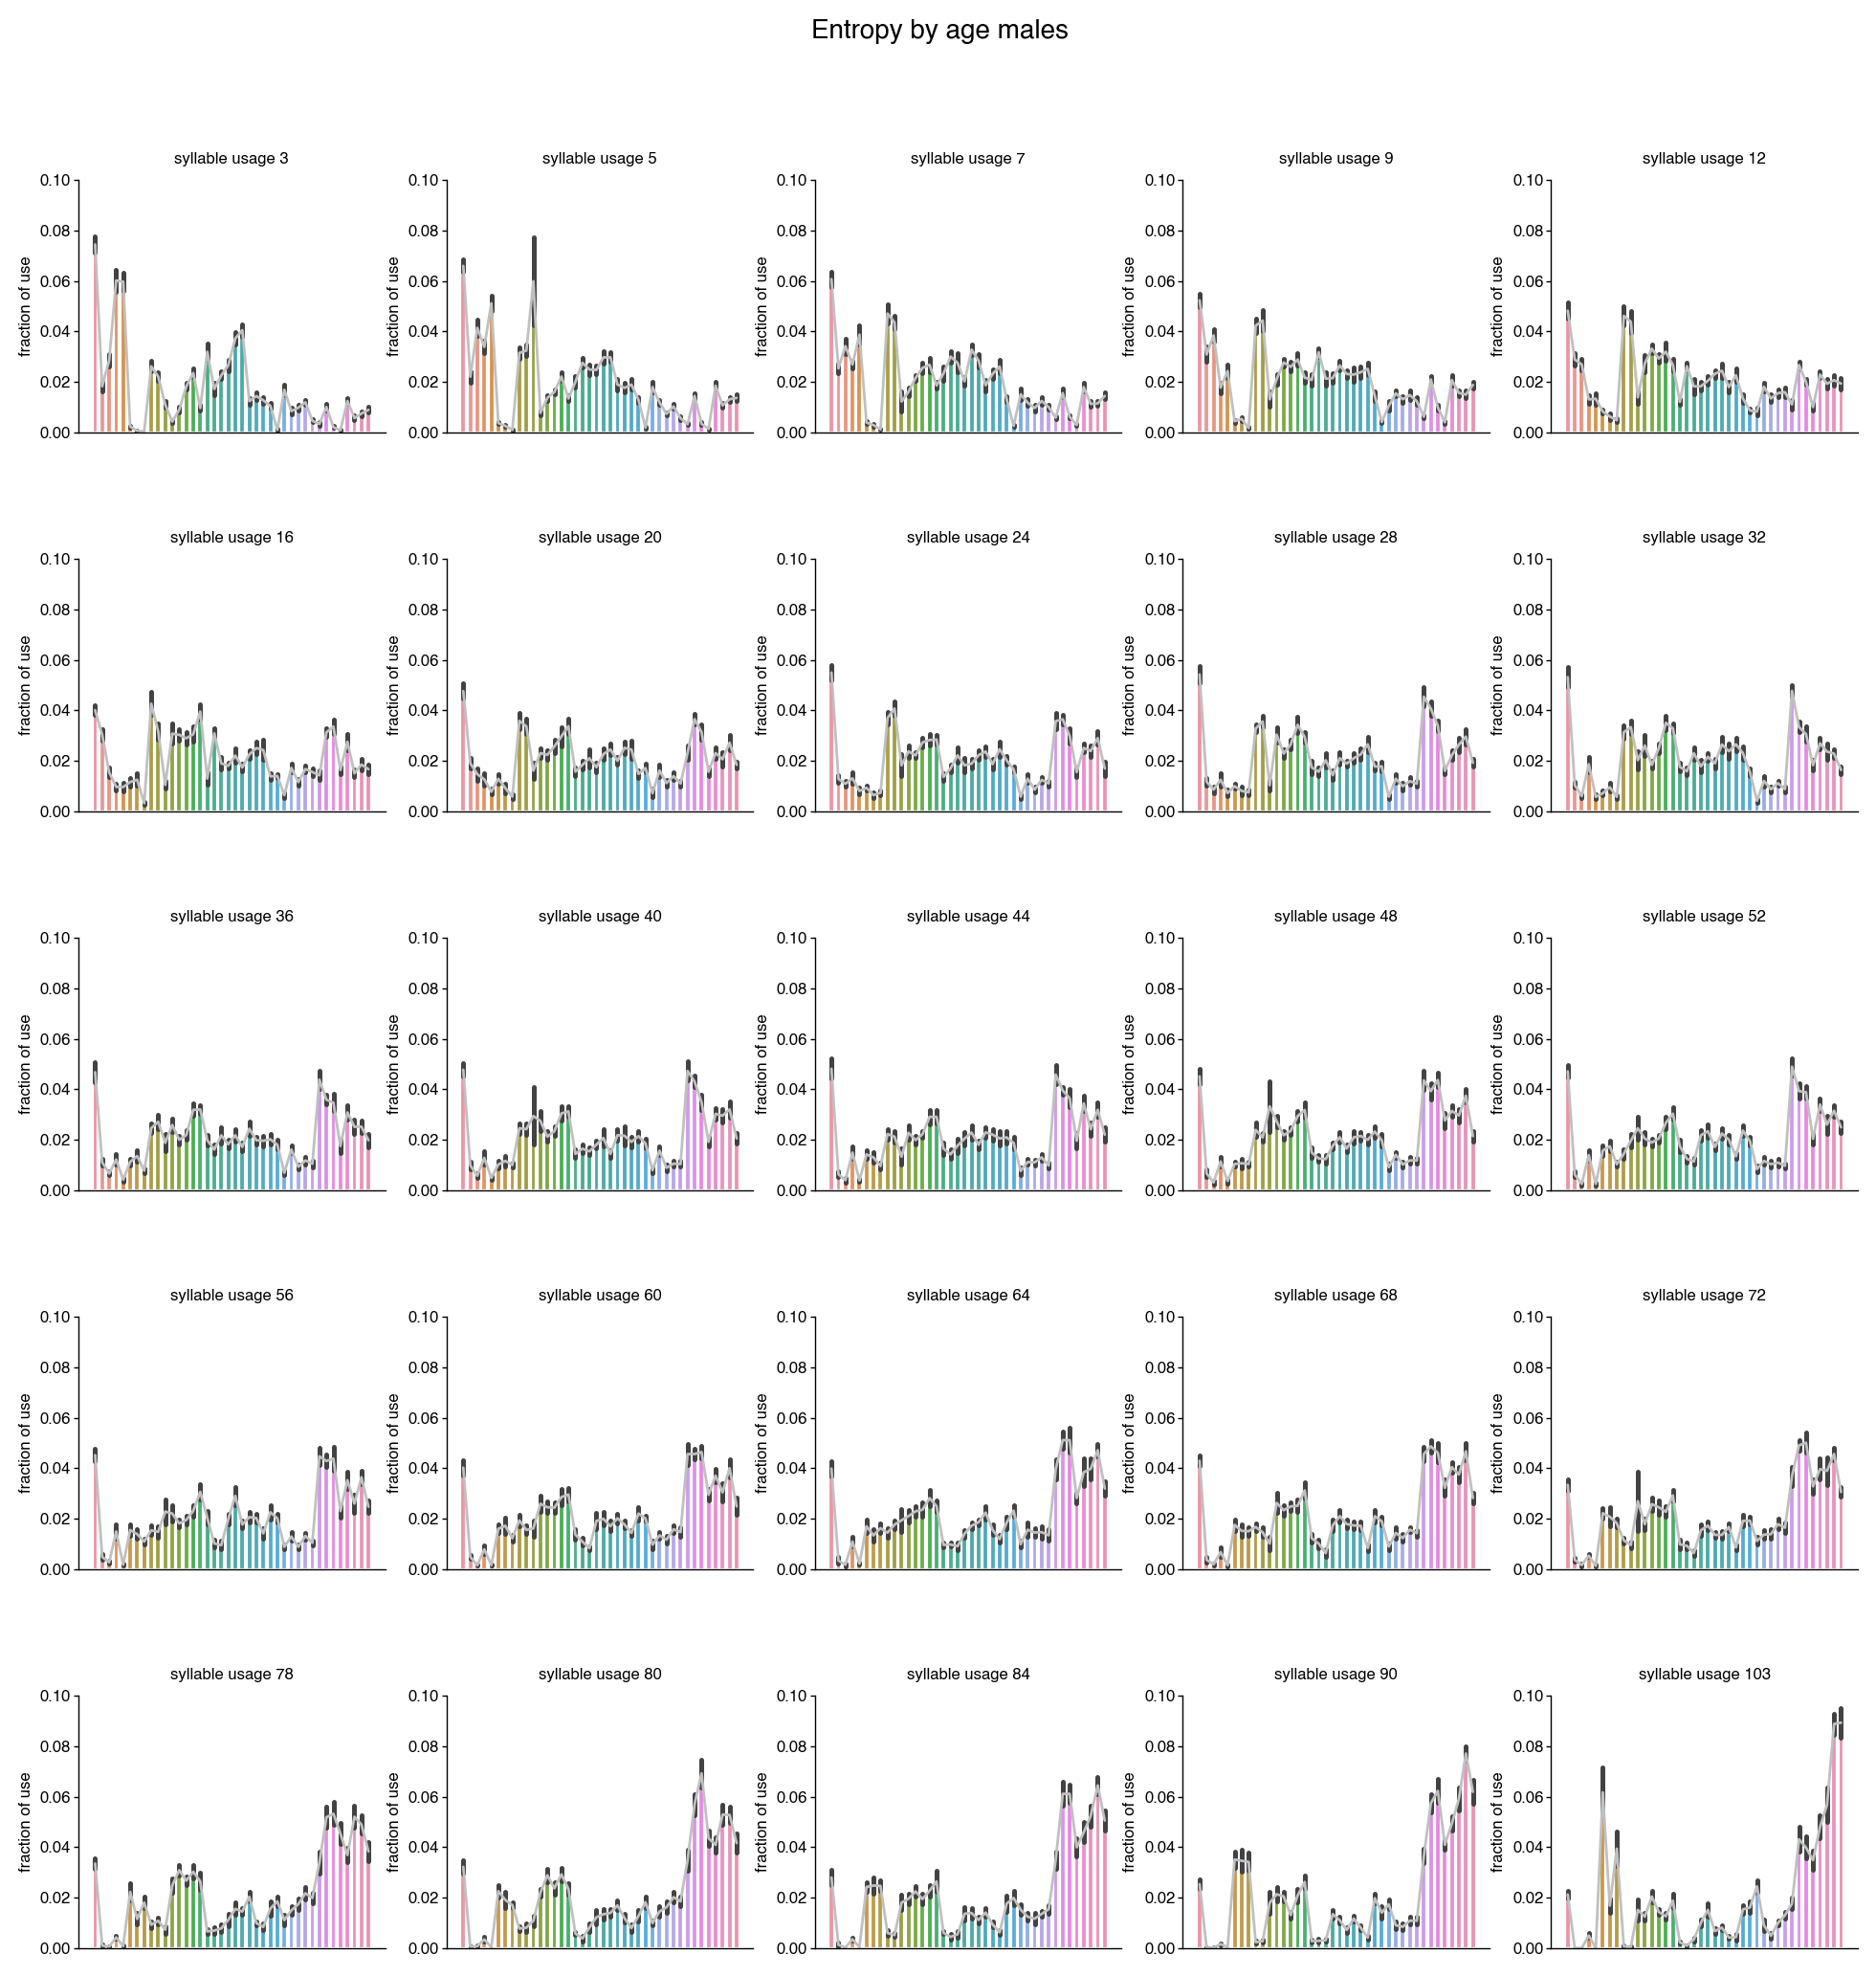

In [9]:
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Entropy by age males", fontsize=10, y=0.95)
n=0
ages=[]
ent=[]

for age,_df in enumerate(data.groupby('remapped_bins')):
    ages.extend(_df[1].index.get_level_values('remapped_bins').to_numpy())
    data_temp = _df[1].to_numpy()[:,s]
    ent.extend(scipy.stats.entropy(data_temp, axis=1))
    ax = plt.subplot(5, 5, n + 1)
    sns.barplot(data_temp, errorbar='se',ax=ax)
    sns.lineplot(np.mean(data_temp, axis=0),ax=ax, color='silver')
    ax.set_title('syllable usage ' + str(_df[1].index.get_level_values('remapped_bins').unique().to_numpy()[0]))
    ax.set_ylim(0,0.1)
    ax.set_xticks([])
    ax.set_ylabel('fraction of use')
    n=n+1
    sns.despine()

In [10]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'C_entropy_examples.pdf', bbox_inches='tight')

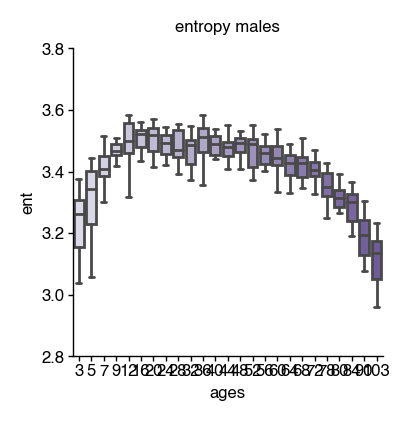

In [13]:
# plot entropy values
df=pd.DataFrame()
df['ages']=ages
df['ent']=ent
cmm_mod = sns.blend_palette(colors, n_colors=25)
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
#sns.lineplot(data=df, x="ages", y="ent", estimator='mean', errorbar='se', c='black')
sns.boxplot(data=df, x="ages", y="ent",showfliers=False, palette=cmm_mod)
#sns.scatterplot(data=df, x="ages", y="ent",color='purple', alpha=0.50,s=10)
ax.set_title('entropy males')
ax.set_ylim(2.8,3.8)
sns.despine()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'C_entropy_males.pdf', bbox_inches='tight')